# Libraries

In [1]:
import os
import sys
sys.path.append('/home/kurose/Desktop/master/viu_master_thesis')

import importlib
import models.model_utils

importlib.reload(models.model_utils)
from models.model_utils import load_dataset, get_input_shape, f1_score, get_callbacks, save_and_print_model, get_metrics, plot_metrics

import tensorflow as tf
import keras_tuner as kt
import pandas as pd

tf.random.set_seed(42)

2024-11-06 20:50:42.754186: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 20:50:42.758554: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 20:50:42.772554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 20:50:42.798403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 20:50:42.805869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 20:50:42.824010: I tensorflow/core/platform/cpu_feature_gu

# Model 2

## Dataset 

In [2]:

train, val, _ = load_dataset(batch_size=2)

## Architecture

In [3]:
def model_builder_v2(hp, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=32, step=8),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Second Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=64, step=16),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Third Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Fourth Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv4_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Global Average Pooling 3D instead of Flatten
    x = tf.keras.layers.GlobalAveragePooling3D()(x)

    # Dense Layer
    x = tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=48, step=16),
        activation='relu'
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    x = tf.keras.layers.Dense(
        units=hp.Int('dense_units_2', min_value=4, max_value=12, step=4),
        activation='relu'
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
    
    # Set Adam Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    )

    # Compile Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=get_metrics() 
    )

    return model

In [4]:
input_shape = get_input_shape(train)

tuner = kt.BayesianOptimization(
    lambda hp: model_builder_v2(hp, input_shape),
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner',
    project_name='v2'
)

callbacks = get_callbacks(
    checkpoint_path='best_model_v2_tuner.weights.h5',
    monitor_metric='val_accuracy',
    patience=10,
    reduce_factor=0.1,
    reduce_patience=5,
    reduce_min_lr=1e-6)


tuner.search(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = model_builder_v2(best_hps, input_shape)


Trial 10 Complete [00h 06m 07s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5
Total elapsed time: 01h 01m 23s


In [5]:

trials = tuner.oracle.get_best_trials(num_trials=10)

results = []
for trial in trials:
    trial_info = trial.hyperparameters.values
    trial_info['score'] = trial.score
    results.append(trial_info)

results_df = pd.DataFrame(results)

print(results_df)

   conv1_filters  conv2_filters  conv3_filters  conv4_filters  dense_units  \
0             32             32             64            192           32   
1             24             32             64            128           48   
2             24             32             96            192           16   
3             32             32            128            192           48   
4             32             64             64            128           32   
5             32             64             64            128           48   
6             16             48            128            128           32   
7             32             64            128            128           16   
8             32             32            128            192           16   
9             32             32             96            128           16   

   dense_units_2  learning_rate  score  
0              8       0.004864    0.5  
1             12       0.004782    0.5  
2             12  

In [6]:
print(results_df.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & conv1_filters & conv2_filters & conv3_filters & conv4_filters & dense_units & dense_units_2 & learning_rate & score \\
\midrule
0 & 32 & 32 & 64 & 192 & 32 & 8 & 0.004864 & 0.500000 \\
1 & 24 & 32 & 64 & 128 & 48 & 12 & 0.004782 & 0.500000 \\
2 & 24 & 32 & 96 & 192 & 16 & 12 & 0.000112 & 0.500000 \\
3 & 32 & 32 & 128 & 192 & 48 & 8 & 0.007121 & 0.500000 \\
4 & 32 & 64 & 64 & 128 & 32 & 4 & 0.000202 & 0.500000 \\
5 & 32 & 64 & 64 & 128 & 48 & 8 & 0.003366 & 0.500000 \\
6 & 16 & 48 & 128 & 128 & 32 & 8 & 0.000133 & 0.500000 \\
7 & 32 & 64 & 128 & 128 & 16 & 8 & 0.000140 & 0.500000 \\
8 & 32 & 32 & 128 & 192 & 16 & 12 & 0.002597 & 0.500000 \\
9 & 32 & 32 & 96 & 128 & 16 & 4 & 0.002953 & 0.500000 \\
\bottomrule
\end{tabular}



In [7]:
save_and_print_model(model, file_path="model_v2_tuner.png")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 33, 128, 128,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 33, 128, 128,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 33, 128, 128,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 16, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 16, 64, 64, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 8, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 8, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 32, 32, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 4, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 4, 16, 16, 192) │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 16, 16, 192) │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 16, 16, 192) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 2, 8, 8, 192)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 192)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           26

 Total params: 423,633 (1.62 MB)

 Trainable params: 422,993 (1.61 MB)

 Non-trainable params: 640 (2.50 KB)

Model architecture saved to model_v2_tuner.png


# Training

In [8]:
callbacks = get_callbacks(
    checkpoint_path='best_model_v2_tuner_final.weights.h5',
    monitor_metric='val_accuracy',
    patience=5,
    reduce_factor=0.1,
    reduce_patience=2,
    reduce_min_lr=1e-6)
              
history = model.fit(train, validation_data=val, epochs=25, callbacks=callbacks)

Epoch 1/25
      8/Unknown 38s 4s/step - accuracy: 0.5078 - auc: 0.3285 - f1_score: 0.4143 - loss: 0.9129

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5000 - auc: 0.3363 - f1_score: 0.4033 - loss: 0.9262 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 230.3313 - learning_rate: 0.0049
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.3452 - auc: 0.2891 - f1_score: 0.1123 - loss: 2.5926 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 14.9478 - learning_rate: 0.0049
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.3976 - auc: 0.5402 - f1_score: 0.0958 - loss: 0.7668 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 4.8451 - learning_rate: 0.0049
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6283 - auc: 0.7190 - f1_score: 0.1952 - loss: 0.6843 - val_accuracy: 0.5000 - val_auc: 0.1250 - val_f1_score: 0.3333 - val_loss: 2.8076 - learning_rate: 4.8640e-04
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6116 - auc: 0.6813 - f1_score: 0.4331 - loss: 0.81

Plot saved to model_v2_metrics_tuner.png


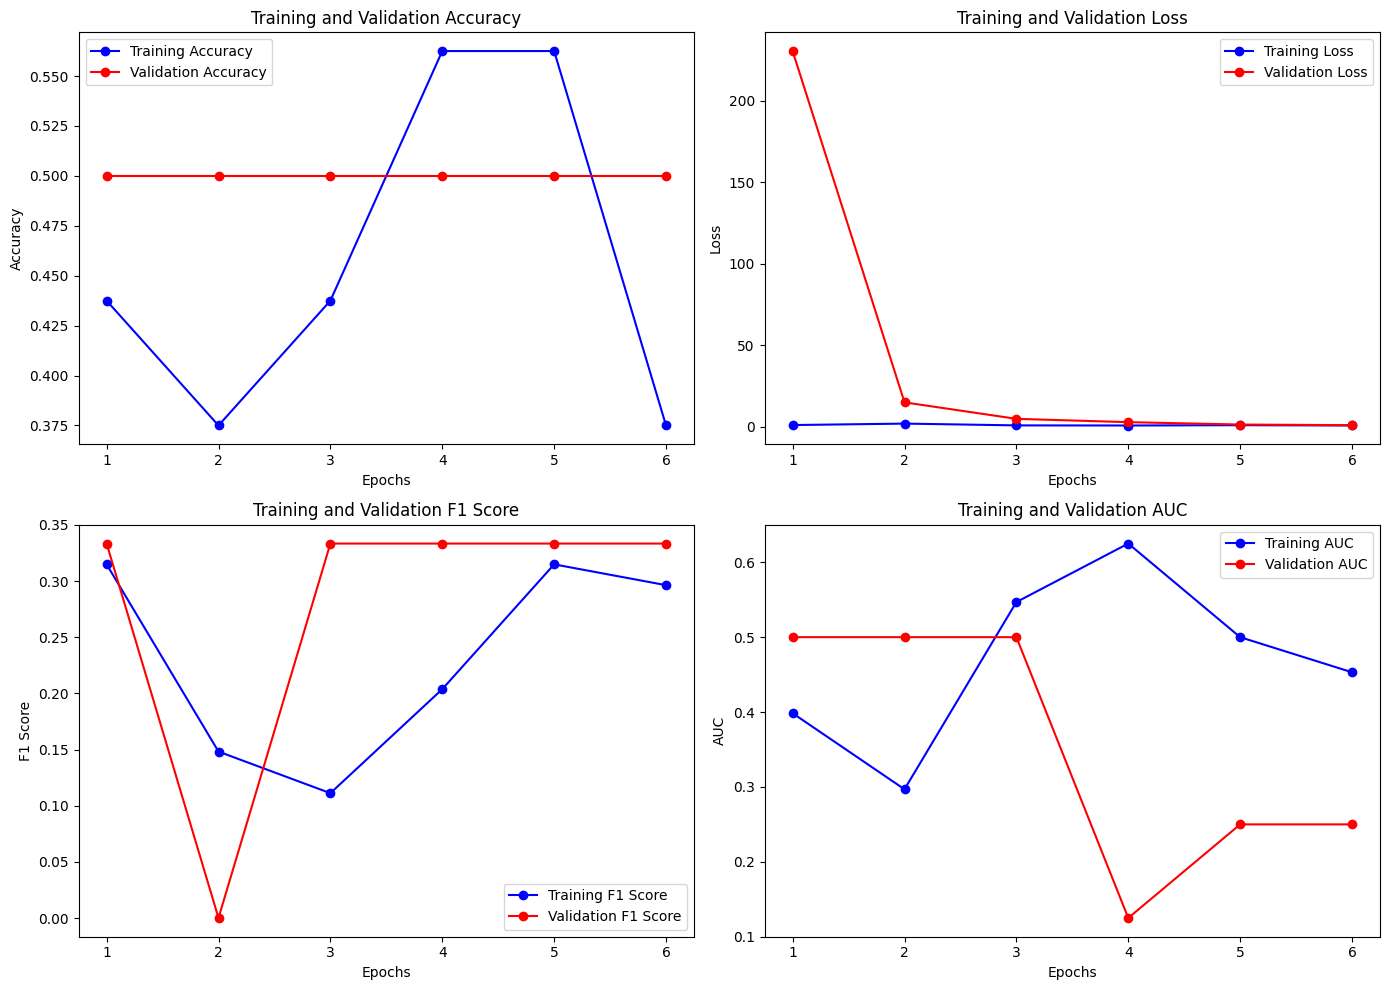

In [9]:
plot_metrics(history, "model_v2_metrics_tuner.png")